In [1]:
from shapes import Point, Rectangle
from environment import Environment2D
from utils import PlotTools
from graph import Graph
from lqr import LQRPlanner
from simulate import Simulator
from plan import Plan, PlanUtils
from search import Searcher

import matplotlib.pyplot as plt
import numpy as np
import polytope as pc
%load_ext autoreload
%autoreload 2

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [2]:
# def generate_waypoints(A, B, x_0, u_nom):
#     T = u_nom.shape[0]
#     x_nom = np.zeros((T, A.shape[0]))
#     x_nom[0] = x_0
#     for t in range(1, T):
#         x_nom[t] = np.dot(A, x_nom[t - 1]) + np.dot(B, u_nom[t - 1])
#     return x_nom

# Env 0

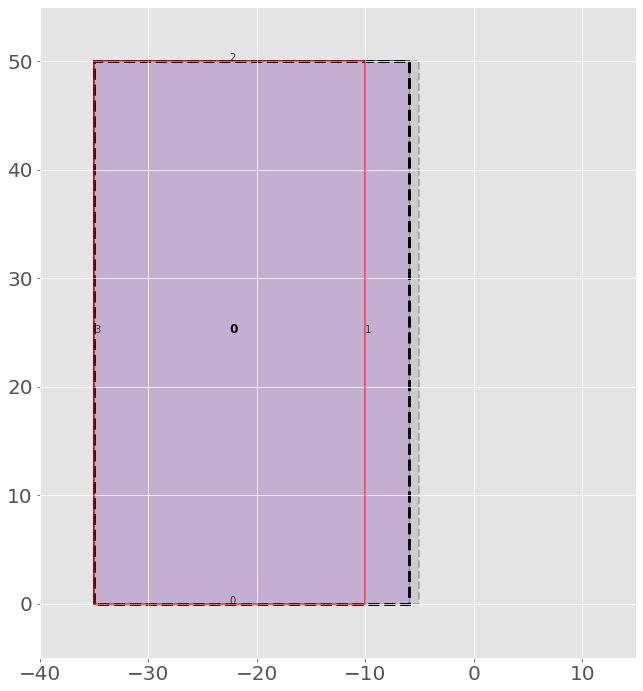

In [3]:
x_lims = [-40,15]
y_lims = [-5,55]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -35,0,25,50,0)
rec_0.set_error_bounds(np.array([0,-5,0,0]), np.array([0,5,0,0]))
# rec_0.set_actual_errors(np.array([0,-4,0,0]))
rec_0.set_actual_errors(np.array([0,4,0,0]))
fig, ax = plt.subplots()
env.add_rectangles([rec_0])
env.plot(ax=ax)
env.rectangles[0].as_poly["actual"].plot(ax=ax)

In [4]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = np.eye(2)
R_lqr = np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

dx = 1
Q = np.eye(2) * 0.1
R = 1
T = 50
x0 = [0,0]
x_noms = np.zeros((T,2))
x_noms[:,1] = np.arange(0,T*dx, dx)
u_noms = np.zeros((T,2))
u_noms[:,1] = np.ones(T) * (dx/dt)

x_est_0 = x0
P_est_0 = np.eye(2)

### Simulator stuff

In [6]:
sim = Simulator(env)
sim.set_motion(A, B, Q)
sim.set_obs(R)
sim.set_gain(lqr_planner.lqr_gain)
sim.set_init_est(x_est_0, P_est_0)
num_iters = 100
xs, x_ests, x_bars = sim.run(num_iters, x0, P_est_0, x_noms, u_noms)

100%|██████████| 100/100 [00:02<00:00, 40.31it/s]


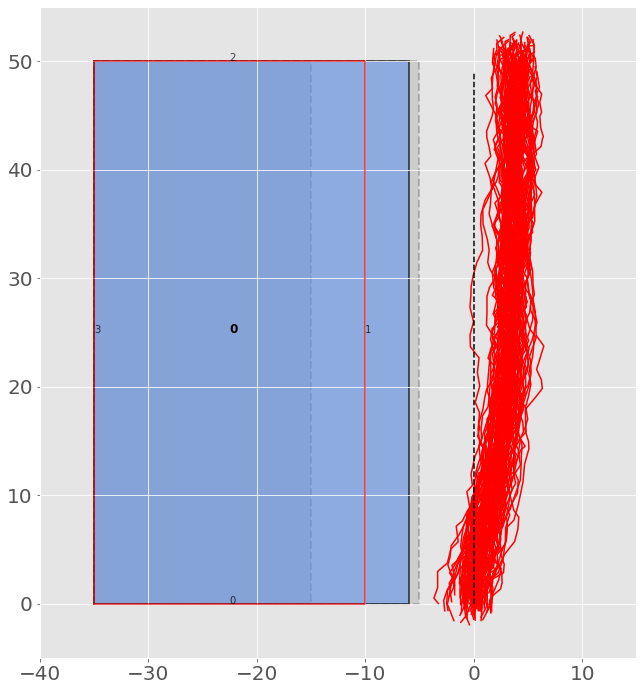

In [7]:
env.plot()
Point(x0[0],x0[1]).plot()
sim.plot_trajs(xs, x_noms)

### Graph exploration

In [5]:
x_range = np.array([x_lims, y_lims])
g = Graph(x0, x_range, env, lqr_planner)
g.clear()
g.build(1000)

Sampling took: 0.05 s.
Connecting took: 7.19 s.


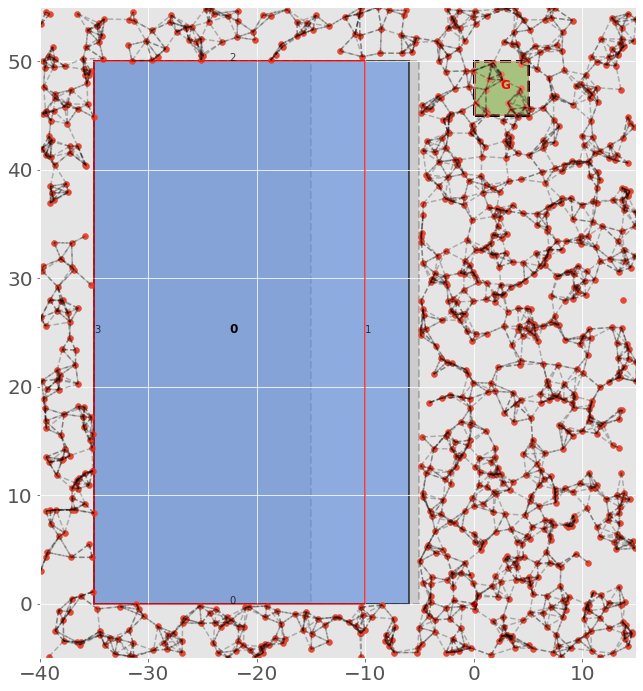

In [6]:
fig, ax = plt.subplots()
goal_region = Rectangle(-1, 0,45,5,5,0)
g.plot(ax=ax)
goal_region.plot(ax=ax,as_goal=True)
goal_region.as_poly["original"].plot(ax=ax)

In [7]:
R = 0.1
kmax = 100
searcher = Searcher(g)
searcher.set_source()
searcher.initialize_open(Q, R, P_est_0, kmax)
searcher.set_goal(goal_region.as_poly["original"])

In [9]:
test=[p for p in searcher.P_open]
p_test = test[0]
print(p_test.Nu[0].at_config(p_test.Sn[-1], 0))

([-5.], [0.])


In [11]:
p_test.Sn

[array([1])]

In [12]:
searcher.explore(0.9)

T = [[0. 0.]
 [0. 0.]]
c = [-5.]
G = [0.]


ValueError: shapes (2,2) and (1,) not aligned: 2 (dim 1) != 1 (dim 0)

# Env 1

In [321]:
x_lims = [-10,10]
y_lims = [-5,5]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -6.5,-3,3,5,0)
rec_1 = Rectangle(1, 1,-1,3,3,0)
rec_2 = Rectangle(2, -10,5,20,1,0)
rec_3 = Rectangle(3, -10,-6.5,20,1,0)
rec_4 = Rectangle(4, -2.5,4.5,5,0.5,0)

rec_0.set_error_bounds(np.array([0,0,0,0]), np.array([0,1.5,1.5,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1.5,0]))
rec_2.set_error_bounds(np.array([-0.5,0,0,0]), np.array([0.5,0,0,0]))

rec_0.set_actual_errors(np.array([0,0,1.5,0]))
rec_1.set_actual_errors(np.array([0,0,1.5,0]))
rec_2.set_actual_errors(np.array([-0.5,0,0,0]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3])
# env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4])
# env.add_rectangles([rec_0, rec_1, rec_3])

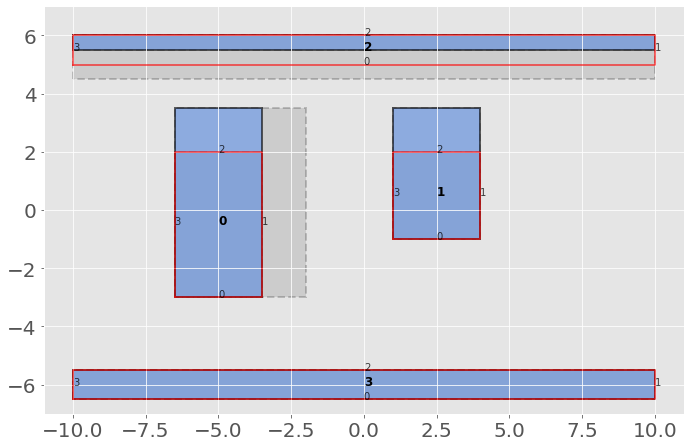

In [322]:
env.plot()

In [323]:
dt = 0.2
A = np.eye(2); B = dt*np.eye(2)
Q_lqr = 10*np.eye(2)
R_lqr = np.eye(2)
lqr_planner = LQRPlanner(Q_lqr, R_lqr, A, B)

Q = np.eye(2) * 0.001
R = 0.1
T = 280
u_noms = np.zeros((T - 1, 2))
for t in range(T - 1):
    u_noms[t] = [0.3, 0]
x0 = [-9, 3.8]
x_noms = generate_waypoints(A, B, x0, u_noms)

x_est_0 = x0
P_est_0 = np.eye(2)

sim = Simulator(env)
sim.set_motion(A, B, Q)
sim.set_obs(R)
sim.set_gain(lqr_planner.lqr_gain)
sim.set_init_est(x_est_0, P_est_0)

In [324]:
# xs = sim.rollout(x0, x_noms, u_noms)

In [325]:
num_iters = 20
xs, x_ests, x_bars = sim.run(num_iters, x0, 0.0*np.eye(2), x_noms, u_noms)

100%|██████████| 20/20 [00:33<00:00,  1.66s/it]


In [63]:
# sim.plot_trajs(xs, x_noms)

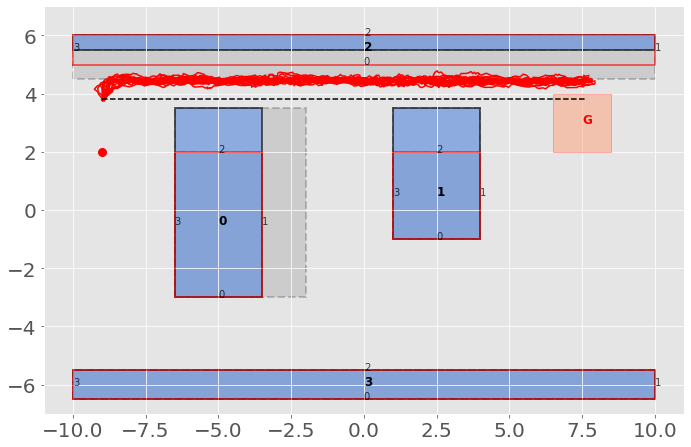

In [326]:
env.plot()
x_start = Point(-9, 2)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)
sim.plot_trajs(xs, x_noms)

# Env 2

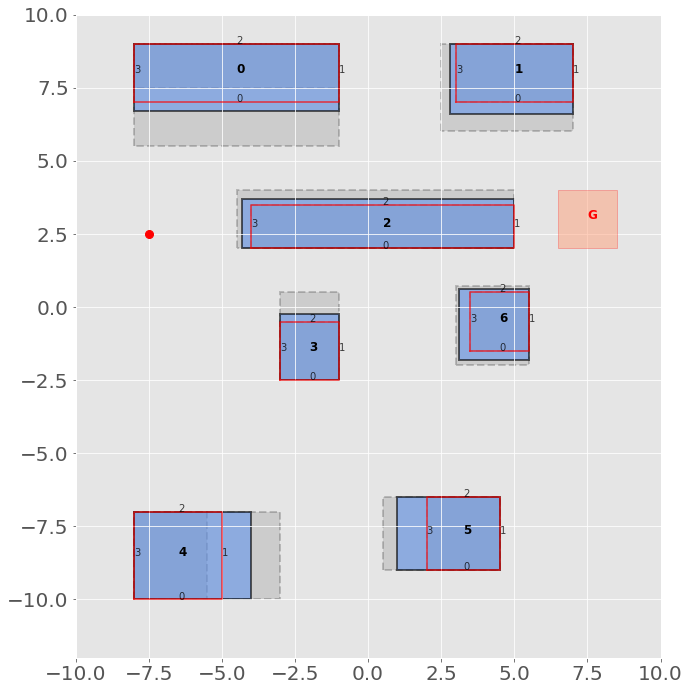

In [37]:
x_lims = [-10,10]
y_lims = [-12,10]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -8,7,7,2,0)
rec_1 = Rectangle(1, 3,7,4,2,0)
rec_2 = Rectangle(2, -4,2,9,1.5,0)
rec_3 = Rectangle(3, -3,-2.5,2,2,0)
rec_4 = Rectangle(4, -8,-10,3,3,0)
rec_5 = Rectangle(5, 2,-9,2.5,2.5,0)
rec_6 = Rectangle(6, 3.5,-1.5,2,2,0)

rec_0.set_error_bounds(np.array([-0.5,0,0,0]), np.array([1.5,0,0,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([1,0,0,0.5]))
rec_2.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0.5,0.5]))
rec_3.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1,0]))
rec_4.set_error_bounds(np.array([0,-0.5,0,0]), np.array([0,2,0,0]))
rec_5.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0,1.5]))
rec_6.set_error_bounds(np.array([0,0,0,0]), np.array([0.5,0,0.2,0.5]))

rec_0.set_actual_errors(np.array([0.3,0,0,0]))
rec_1.set_actual_errors(np.array([0.4,0,0,0.2]))
rec_2.set_actual_errors(np.array([0,0,0.2,0.3]))
rec_3.set_actual_errors(np.array([0,0,0.25,0]))
rec_4.set_actual_errors(np.array([0,1,0,0]))
rec_5.set_actual_errors(np.array([0,0,0,1]))
rec_6.set_actual_errors(np.array([0.3,0,0.1,0.4]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4, rec_5, rec_6])

env.plot()
x_start = Point(-7.5, 2.5)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)